In [1]:
dir_path = '00_Msc_Project_Test_Images/'
fn_tflite_az = 'tf_mnist_model_az.tflite'
fn_tflite_09 = 'tf_mnist_model_09.tflite'
class_labels = ['0123456789', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']

In [2]:
from ImageUtilities import *
from MNISTUtilities import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

In [3]:
def preprocess(img_seg, flatten=True, scale_features=True, display_steps=False):
    rows, cols = img_seg.shape
    
    #(1) Fit to 20x20 box preserving aspect ratio
    max_dim = 20
    img_fitted = fitImage(img_seg, max_dim)
    rows, cols = img_fitted.shape
    
    if(display_steps == True):
        plt.title("{}, {}".format(i, img_fitted.shape))
        plt.imshow(img_fitted, cmap='gray')
        plt.show()
    
    #(2) Pad to 28x28 image
    reqr, reqc = 28, 28
    img_padded = padImage(img_fitted, reqr, reqc)

    if(display_steps == True):
        plt.title(i)
        plt.imshow(img_padded, cmap='gray')
        plt.show()
    
    #(3) Transform / Center image
    shX, shY = getTransform(img_padded)
    img_transformed = transformImage(img_padded ,shX, shY)
    
    if(display_steps == True):
        plt.title(i)
        plt.imshow(img_transformed, cmap='gray')
        plt.show()
        
    #(4) Flatten image
    if(flatten == True):
        img_transformed = np.reshape(img_transformed, (1, -1))
        
    #(5) Scale features
    if(scale_features == True):
        img_transformed = img_transformed / 255.0
       
    return img_transformed

In [4]:
def run_predictions(fn, mode, pxl_th, blk_sz, c):
    
    #(0) Load pretrained models
    interpreter_09 = tf.lite.Interpreter(model_path=fn_tflite_09)
    interpreter_09.allocate_tensors()
    interpreter_az = tf.lite.Interpreter(model_path=fn_tflite_az)
    interpreter_az.allocate_tensors()
    interpreter= [interpreter_09, interpreter_az]
    
    #(1) Read image
    img = cv2.imread(dir_path + fn)
    
    #(2) Binarize image
    img_bin = binarize_image(img, block_size=blk_sz, c=c)
    plt.title("Original Image")
    plt.imshow(img_bin, cmap='gray')
    plt.show()

    #(3) Trim image
    img_roi = trim(img_bin, pixel_threshold=pxl_th)
    plt.title("Trimmed Image")
    plt.imshow(img_roi, cmap='gray')
    plt.show()
    
    #(4) Extract characters
    seg_list = segment_image(img_roi)
    n_segs = len(seg_list)
    print("Length of seg_list: ", n_segs)
    for i in range(n_segs):
        seg_list[i] = preprocess(seg_list[i])
        plt.title(str(i) + str(seg_list[i].shape ))
        plt.imshow(seg_list[i].reshape((28, 28)), cmap='gray')
        plt.show()
        
    #(5) Make predictions
    input_details = interpreter[mode].get_input_details()
    ip_idx, ip_shape = input_details[0]['index'], input_details[0]['shape']
    output_details = interpreter[mode].get_output_details()
    op_idx, op_shape = output_details[0]['index'], output_details[0]['shape']
    
    predictions = ["" for i in range(n_segs)]
    for i in range(n_segs):
        input_data = seg_list[i].astype(np.float32)
        interpreter[mode].set_tensor(ip_idx, input_data)
        interpreter[mode].invoke()
        output_data = interpreter[mode].get_tensor(op_idx)
        predictions[i] = class_labels[mode][np.argmax(output_data)]
        
    #(6) Return output
    return img, seg_list, predictions

## Main

#### Test Cases

In [5]:
img_dir = os.listdir(dir_path)
display(img_dir)
test_cases = [
    {"fn": 'test_01_3017864249.jpg', "mode": 0, "pxl_th": 3, "blk_sz": 151, "c": 30,
     "text": ['3', '0', '1', '7', '8', '6', '5', '2', '4', '9']},
    {"fn": 'test_02_2468304911775.jpg', "mode": 0, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['2', '4', '6', '8', '3', '0', '4', '9', '1', '1', '7', '7', '5']},
    {"fn": 'test_03_09.jpg', "mode": 0, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']},
    {"fn": 'test_04_ar.jpg', "mode": 1, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']},
    {"fn": 'test_05_sz.jpg', "mode": 1, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']},
    {"fn": 'test_06_AP.jpg', "mode": 1, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'] },
    {"fn": 'test_07_QZ.jpg', "mode": 1, "pxl_th": 3, "blk_sz": 151, "c": 35,
    "text": ['Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']},
    {"fn": 'test_08_phone_number.jpg', "mode": 0, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['8', '0', '1', '7', '0', '1', '1', '3', '7', '6']},
    {"fn": 'test_09_kolkata.jpg', "mode": 1, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['K', 'O', 'L', 'K', 'A', 'T', 'A']},
    {"fn": 'test_10_700120.jpg', "mode": 0, "pxl_th": 3, "blk_sz": 151, "c": 20,
    "text": ['7', '0', '0', '1', '2', '0']},
    {"fn": 'test_11_1800583.jpg', "mode": 0, "pxl_th": 3, "blk_sz": 151, "c": 30,
    "text": ['1', '8', '0', '0', '5', '8', '3']},
    {"fn": 'test_12_90.jpg', "mode": 0, "pxl_th": 1, "blk_sz": 151, "c": 30,
    "text": ['9', '8', '7', '6', '5', '4', '3', '2', '1', '0']},
]
display(test_cases)

['test_01_3017864249.jpg',
 'test_02_2468304911775.jpg',
 'test_03_09.jpg',
 'test_04_ar.jpg',
 'test_05_sz.jpg',
 'test_06_AP.jpg',
 'test_07_QZ.jpg',
 'test_08_phone_number.jpg',
 'test_09_kolkata.jpg',
 'test_10_700120.jpg',
 'test_11_1800583.jpg',
 'test_12_90.jpg']

[{'fn': 'test_01_3017864249.jpg',
  'mode': 0,
  'pxl_th': 3,
  'blk_sz': 151,
  'c': 30,
  'text': ['3', '0', '1', '7', '8', '6', '5', '2', '4', '9']},
 {'fn': 'test_02_2468304911775.jpg',
  'mode': 0,
  'pxl_th': 3,
  'blk_sz': 151,
  'c': 30,
  'text': ['2', '4', '6', '8', '3', '0', '4', '9', '1', '1', '7', '7', '5']},
 {'fn': 'test_03_09.jpg',
  'mode': 0,
  'pxl_th': 3,
  'blk_sz': 151,
  'c': 30,
  'text': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']},
 {'fn': 'test_04_ar.jpg',
  'mode': 1,
  'pxl_th': 3,
  'blk_sz': 151,
  'c': 30,
  'text': ['A',
   'B',
   'C',
   'D',
   'E',
   'F',
   'G',
   'H',
   'I',
   'J',
   'K',
   'L',
   'M',
   'N',
   'O',
   'P',
   'Q',
   'R']},
 {'fn': 'test_05_sz.jpg',
  'mode': 1,
  'pxl_th': 3,
  'blk_sz': 151,
  'c': 30,
  'text': ['S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']},
 {'fn': 'test_06_AP.jpg',
  'mode': 1,
  'pxl_th': 3,
  'blk_sz': 151,
  'c': 30,
  'text': ['A',
   'B',
   'C',
   'D',
   'E',
   'F',
   'G',
   'H',
   'I'

#### Run Predictions

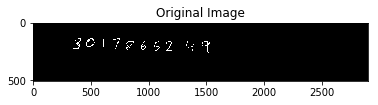

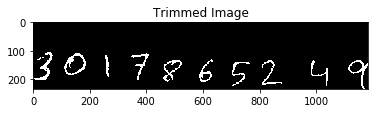

235 1183
235 1183
Length of seg_list:  10


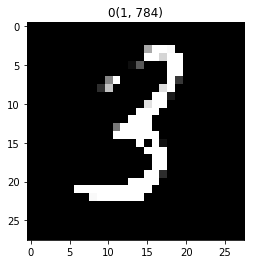

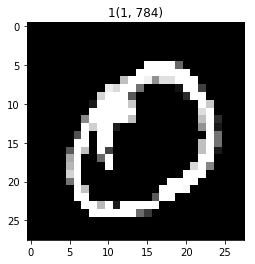

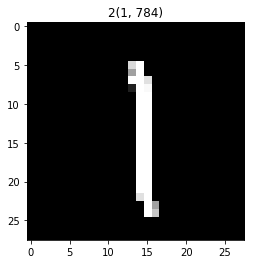

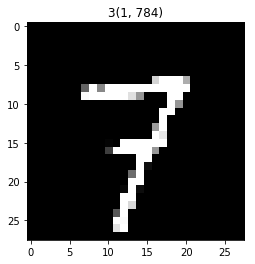

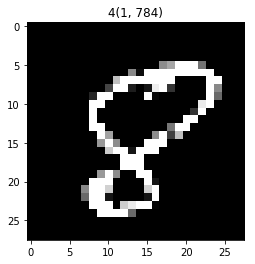

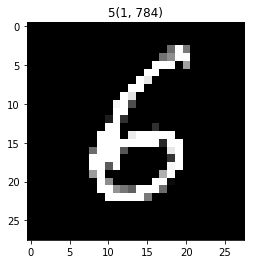

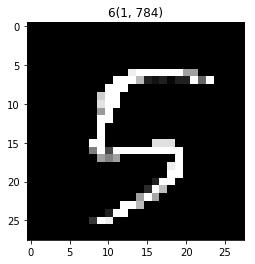

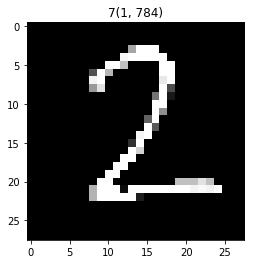

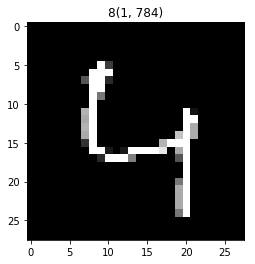

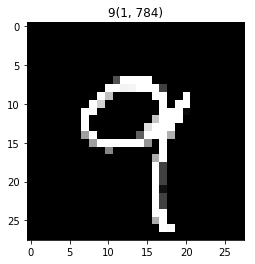

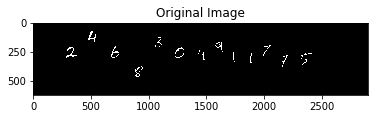

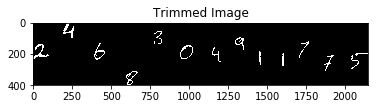

398 2146
398 2146
Length of seg_list:  13


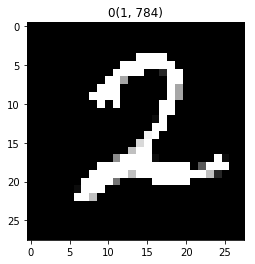

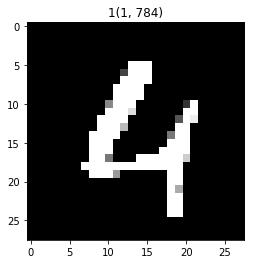

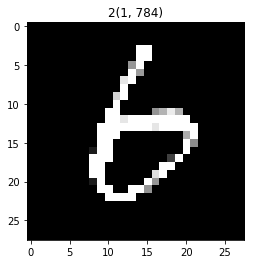

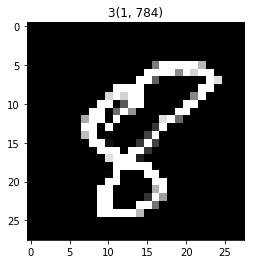

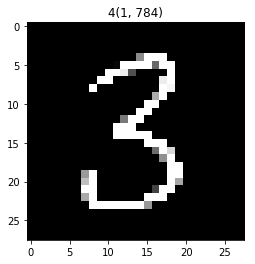

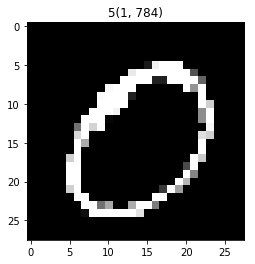

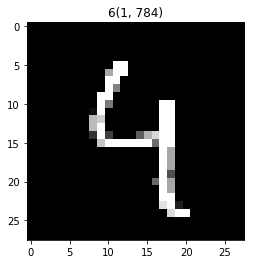

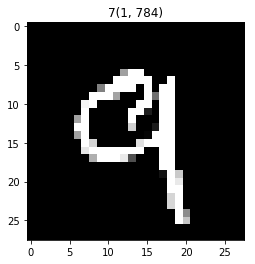

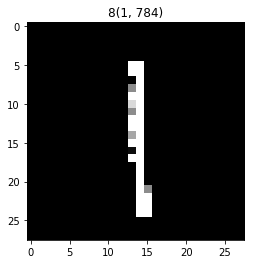

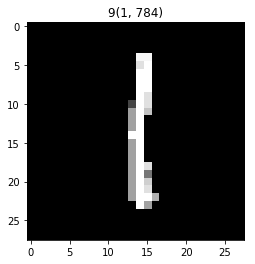

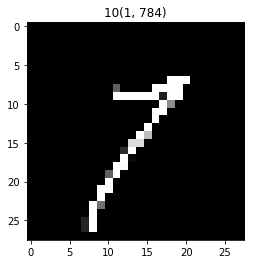

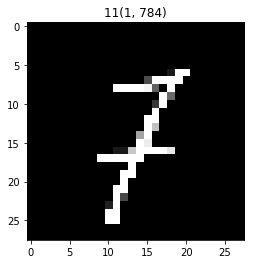

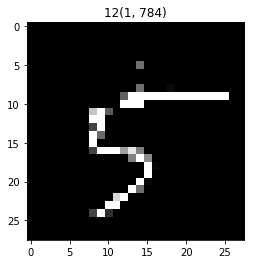

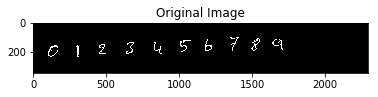

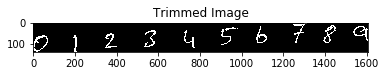

139 1607
139 1607
Length of seg_list:  10


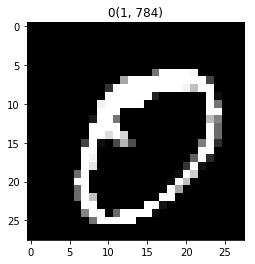

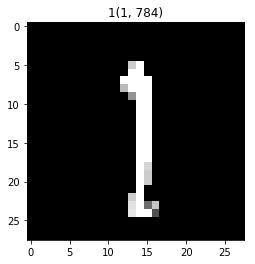

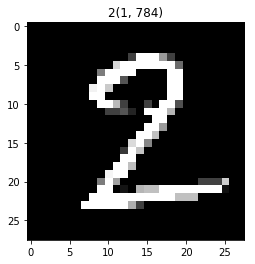

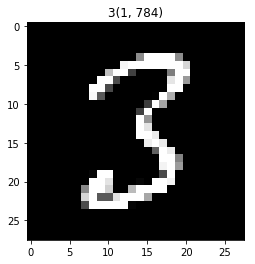

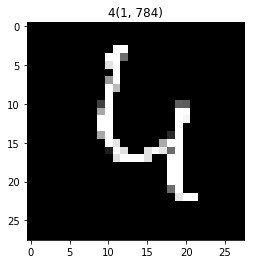

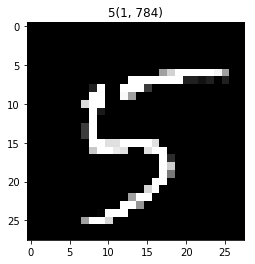

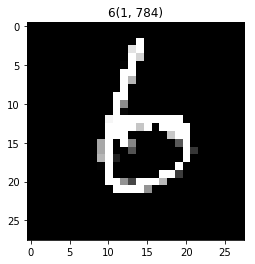

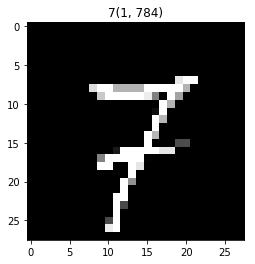

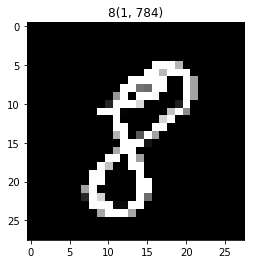

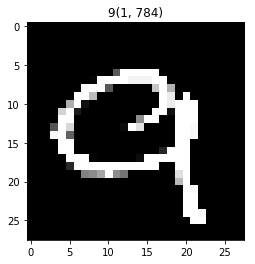

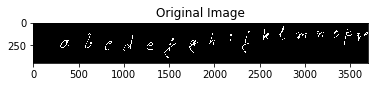

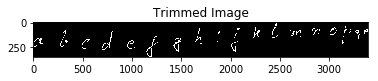

348 3394
348 3394
Length of seg_list:  18


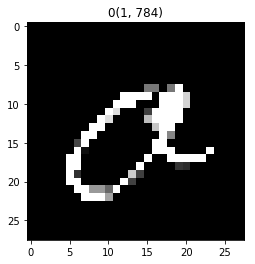

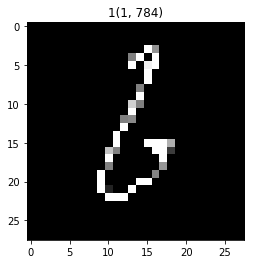

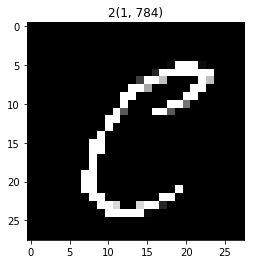

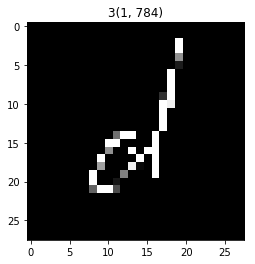

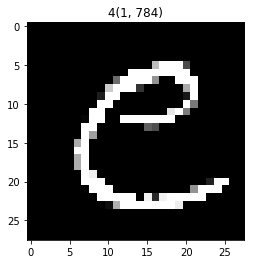

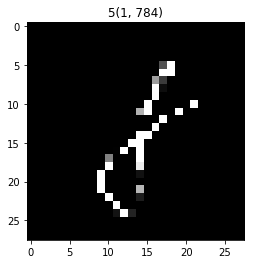

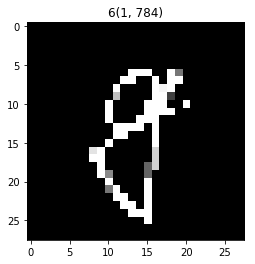

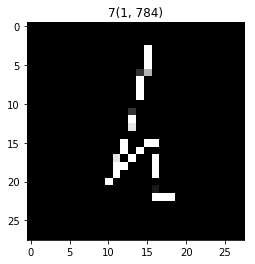

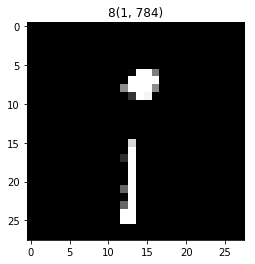

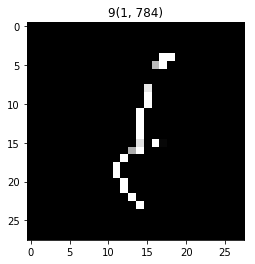

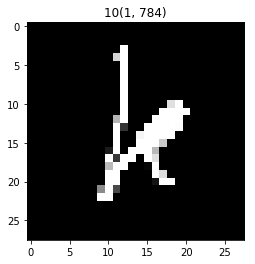

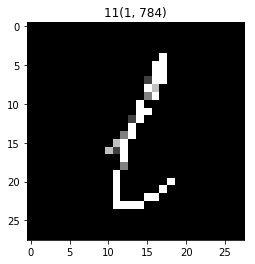

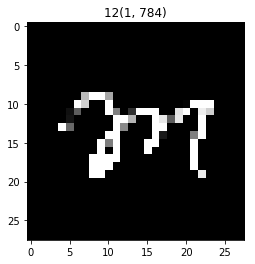

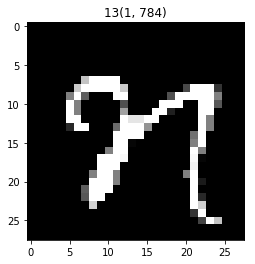

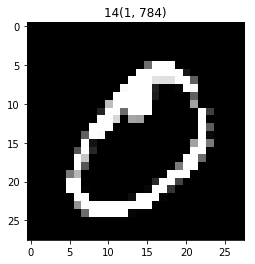

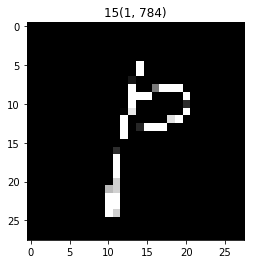

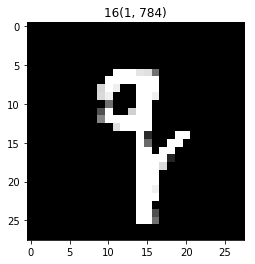

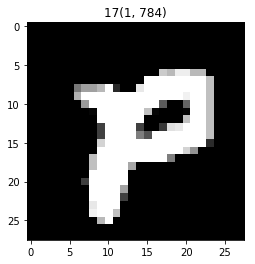

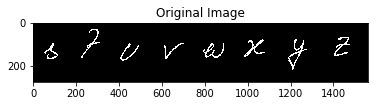

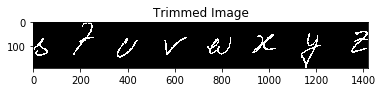

193 1420
193 1420
Length of seg_list:  8


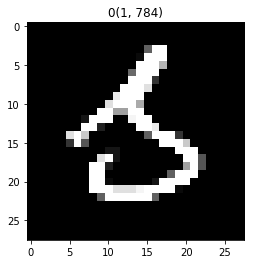

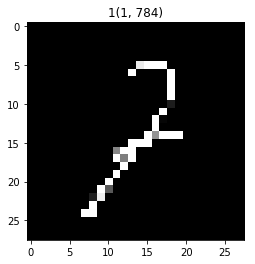

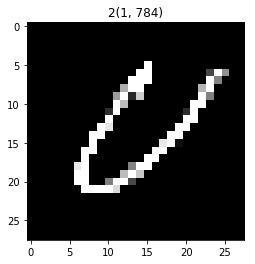

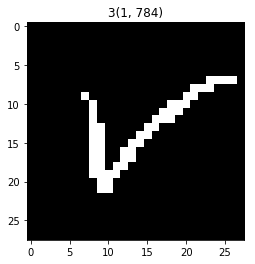

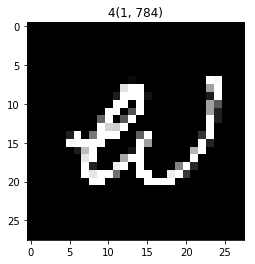

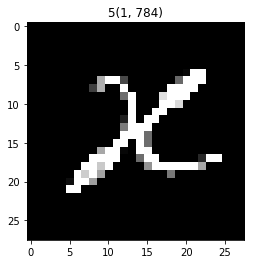

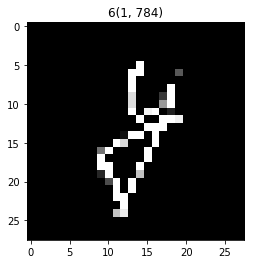

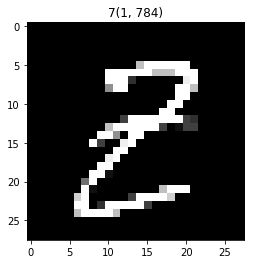

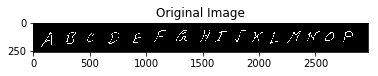

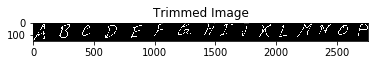

150 2756
150 2756
Length of seg_list:  16


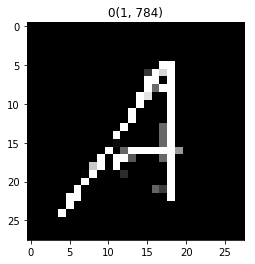

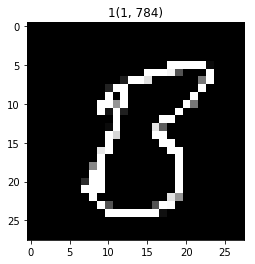

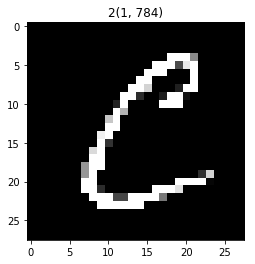

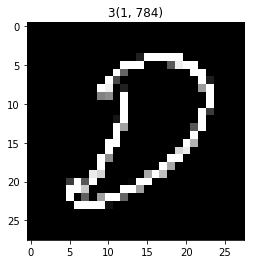

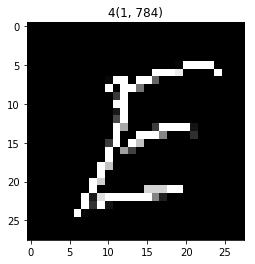

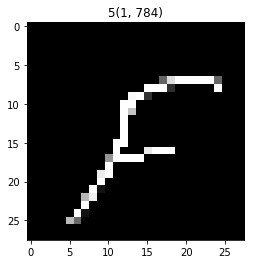

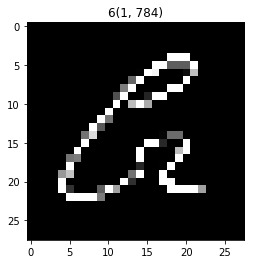

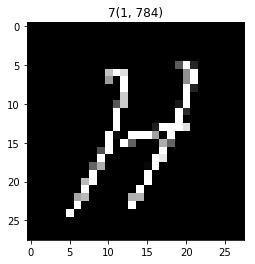

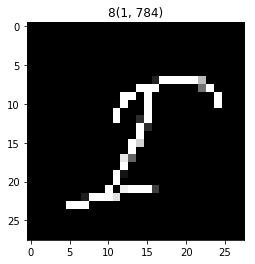

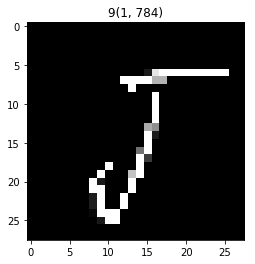

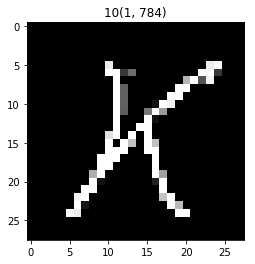

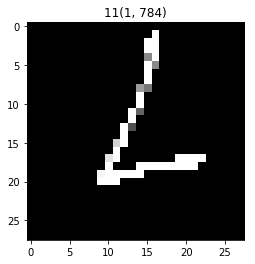

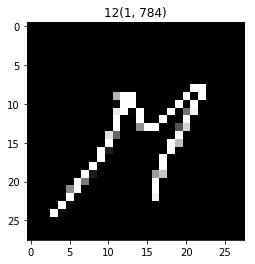

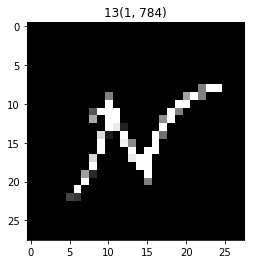

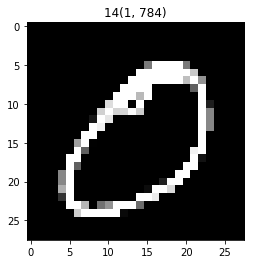

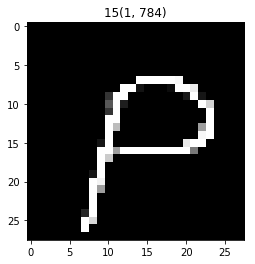

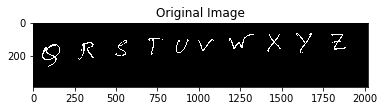

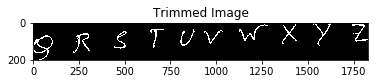

202 1829
202 1829
Length of seg_list:  10


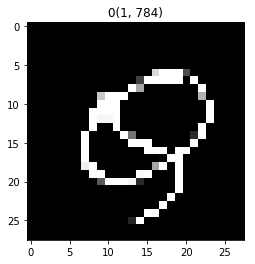

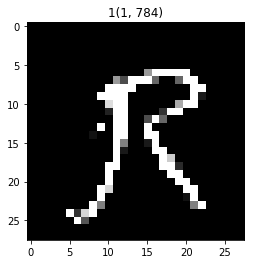

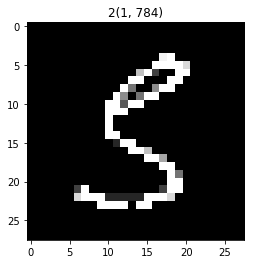

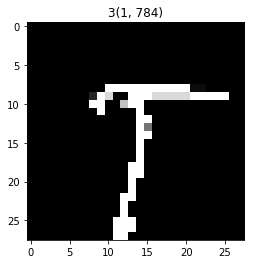

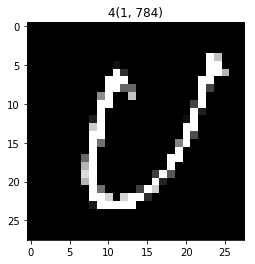

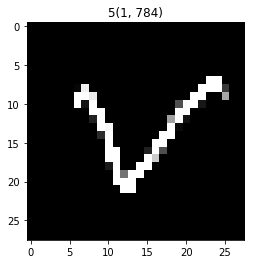

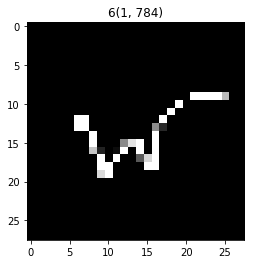

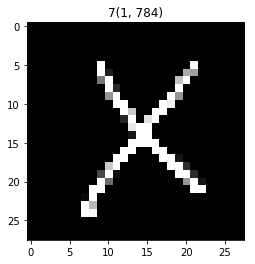

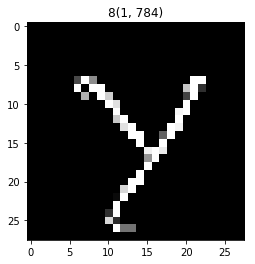

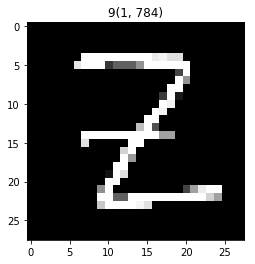

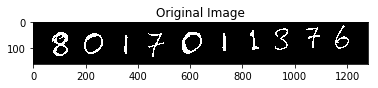

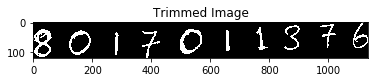

120 1134
120 1134
Length of seg_list:  10


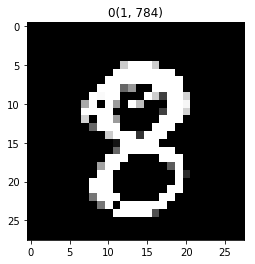

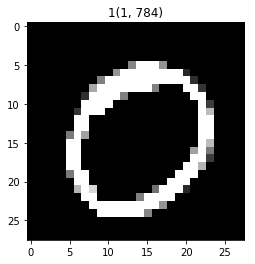

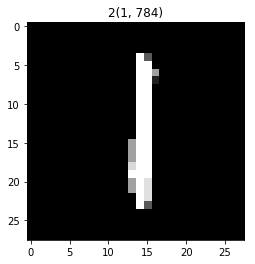

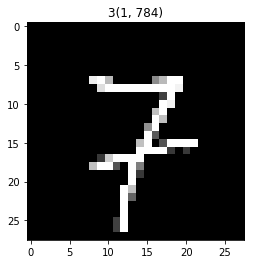

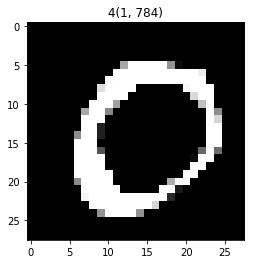

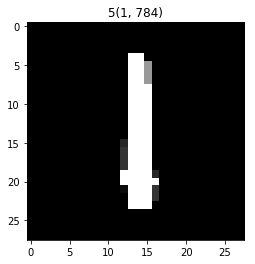

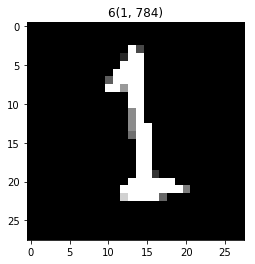

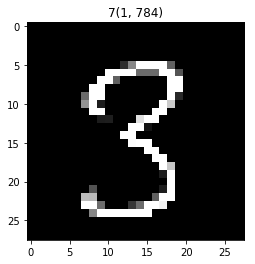

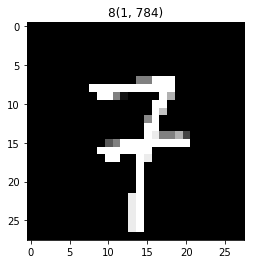

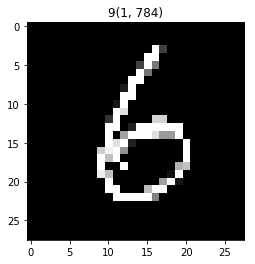

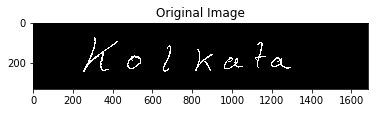

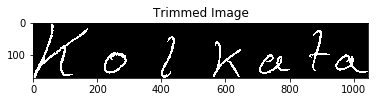

171 1045
171 1045
Length of seg_list:  7


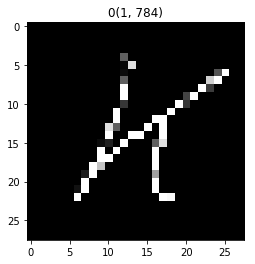

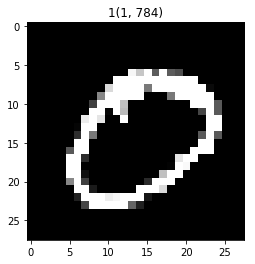

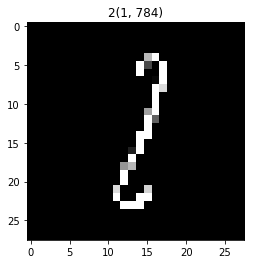

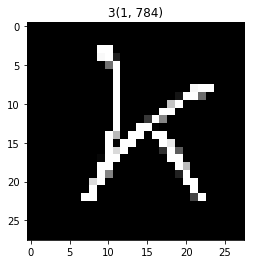

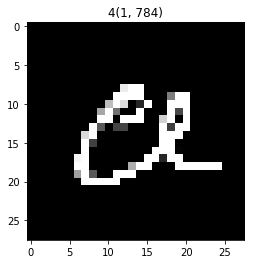

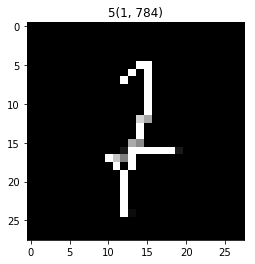

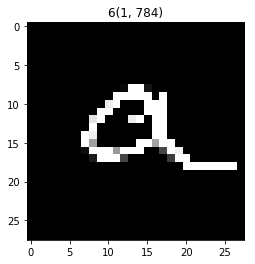

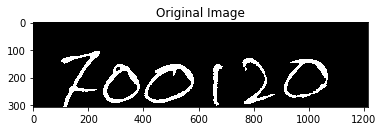

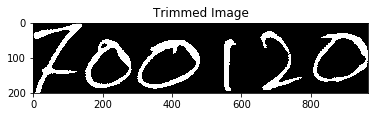

201 966
201 966
Length of seg_list:  6


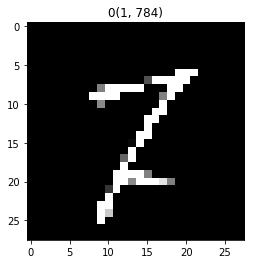

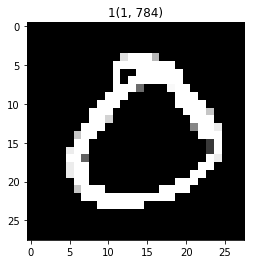

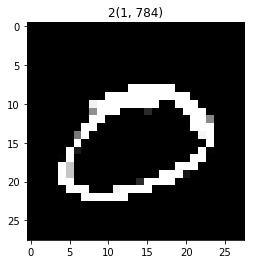

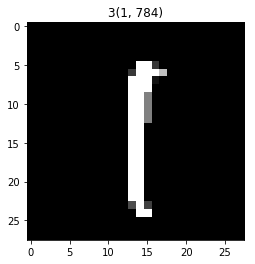

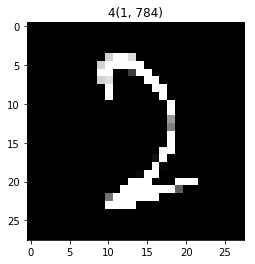

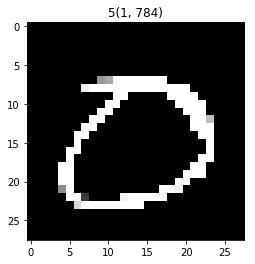

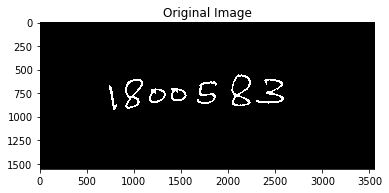

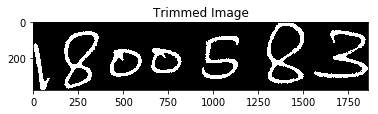

375 1860
375 1860
Length of seg_list:  7


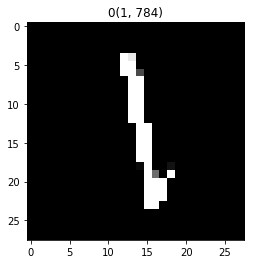

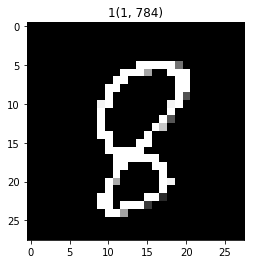

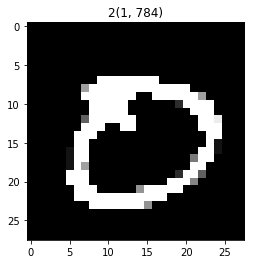

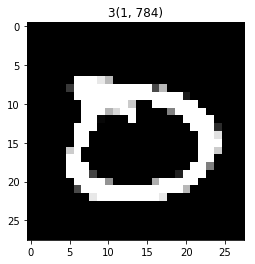

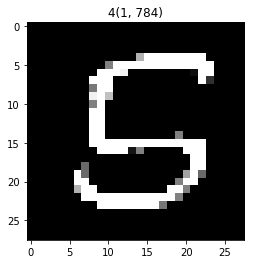

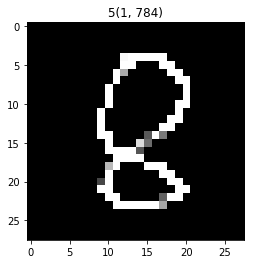

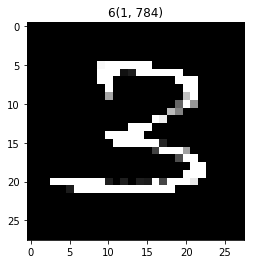

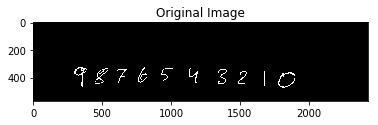

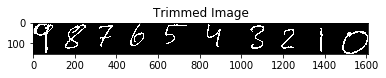

150 1608
150 1608
Length of seg_list:  10


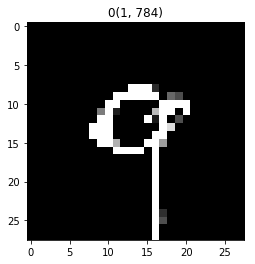

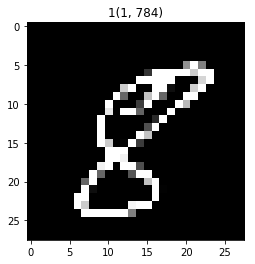

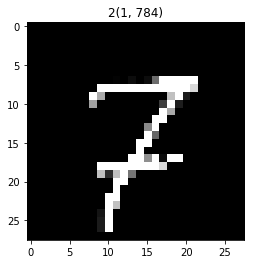

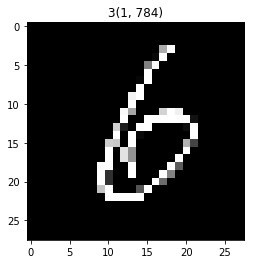

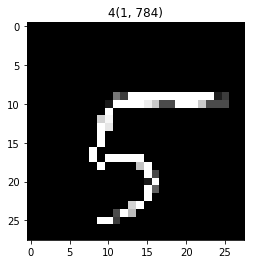

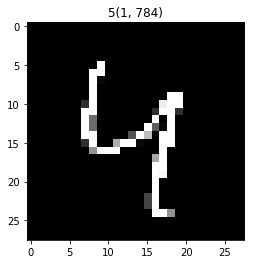

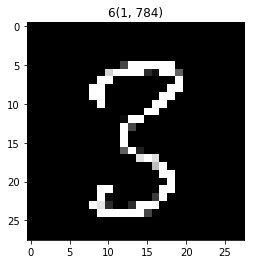

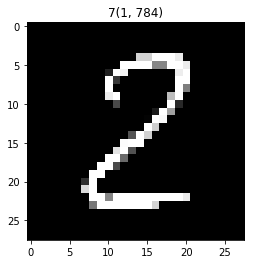

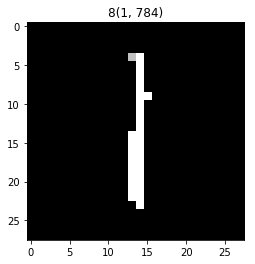

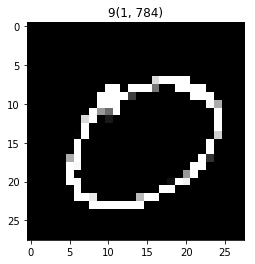

In [6]:
outputs = []
cnt = 0;
for tc  in test_cases:
    cnt+=1
    img, seg_list, preds = run_predictions(tc['fn'], tc['mode'], tc['pxl_th'], tc['blk_sz'], tc['c'])
    
    #Evaluation
    correct, acc = 0, 0
    if(len(tc['text']) == len(preds)):
        correct = 0
        n_preds = len(preds)
        for i in range(n_preds):
            if(tc['text'][i] == preds[i]):
                correct += 1
        acc = correct/n_preds * 100
        
    #Preparing Output
    outputs.append({'id': cnt,
                    'orig_img': img,
                    'orig_labels': tc['text'],
                    'seg_list': seg_list,
                    'pred_labels': preds,
                    'correct': correct,
                    'acc': acc})


================= CASE 1 =================


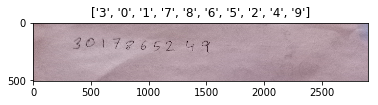

total: 10
 correct: 10
 acc: 100.0
================= CASE 2 =================


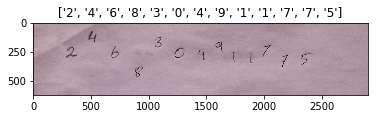

total: 13
 correct: 13
 acc: 100.0
================= CASE 3 =================


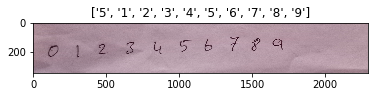

total: 10
 correct: 9
 acc: 90.0
================= CASE 4 =================


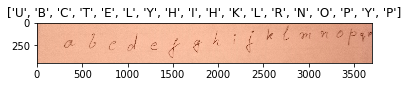

total: 18
 correct: 10
 acc: 55.55555555555556
================= CASE 5 =================


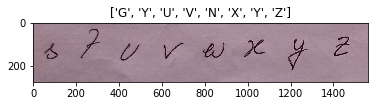

total: 8
 correct: 5
 acc: 62.5
================= CASE 6 =================


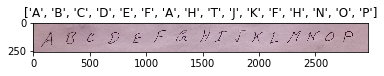

total: 16
 correct: 12
 acc: 75.0
================= CASE 7 =================


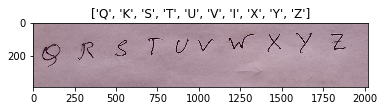

total: 10
 correct: 8
 acc: 80.0
================= CASE 8 =================


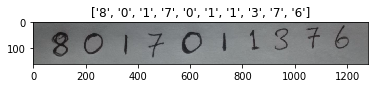

total: 10
 correct: 10
 acc: 100.0
================= CASE 9 =================


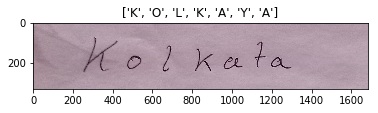

total: 7
 correct: 6
 acc: 85.71428571428571
================= CASE 10 =================


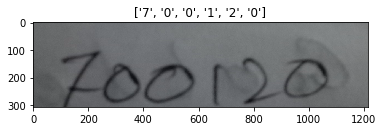

total: 6
 correct: 6
 acc: 100.0
================= CASE 11 =================


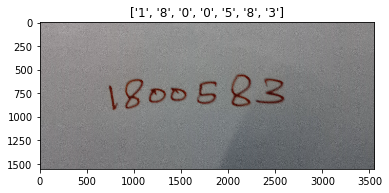

total: 7
 correct: 7
 acc: 100.0
================= CASE 12 =================


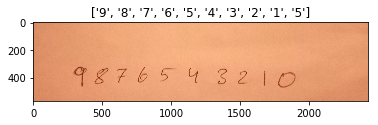

total: 10
 correct: 9
 acc: 90.0


In [7]:
#Display Outputs
i = 0
for op in outputs:
    i+=1
    print("================= CASE {} =================".format(i))
    plt.title(op['pred_labels'])
    plt.imshow(op['orig_img'])
    plt.show()
    
    print("total: {}\n correct: {}\n acc: {}".format(len(op['seg_list']), op['correct'], op['acc']))
    
#     r = 1
#     c = 3
       
#     print("Train Set:")
#     m = X_train.shape[0]
#     data = X_train
#     label = y_train
#     fig = plt.figure(figsize=(9, 3))
#     for i in range(1, 4):
#         k = np.random.randint(m)
#         fig.add_subplot(r, c, i)
#         plt.imshow(data[k].reshape((28, 28)), cmap='gray')
#         plt.title(class_labels[label[k]], fontsize=16)
#         plt.axis('off')
#     plt.show()
    